In [12]:
import numpy as np
from scipy.interpolate import interp1d
import qnm_filter
import sys
import qnm
import random
import argparse
import scipy.linalg as sl
from scipy.special import logsumexp
import matplotlib.pyplot as pl
from pathlib import Path
import glob

In [23]:
def signal_creator():
    global signal, signal220, signal200, t_range
    injected = (100, 0.5)
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega200 = qnm.modes_cache(s=-2,l=2,m=0,n=0)(a=injected[1])[0]

    mmax = 8.4 * 1e-21
    phase1 = np.pi/3 #random.uniform(0, 2*np.pi)
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)
    phase2 = np.pi/3 #random.uniform(0, 2*np.pi)
    A200x = mmax*np.cos(phase2)
    A200y = mmax*np.sin(phase2)

    amp220 = 1
    amp200 = 1

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    signal200 = np.real(amp200 * (A200x + 1j * A200y) * np.exp(-1j * omega200 * np.abs(t_range / mass)))
    signal = signal220+signal200

def injection_evidence(acf_scale):
    fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=0.0)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.condition_data('original_data')
    fit.compute_acfs('original_data')
    temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
    temp_acf[0] = (mmax)**2*acf_scale
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    likelihood220, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 10, model_list=[(2,2,0,'p')])
    likelihood220_200, evidence220_200 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 10, 
                                                  model_list=[(2,2,0,'p'),(2,0,0,'p')])
    nofilter = logsumexp(
        np.array(
            [fit.compute_likelihood(apply_filter=False)]
            * len(massspace)
            * len(chispace)
        )
    )
    
    credible_region = qnm_filter.find_credible_region(likelihood220_200, num_cpu=10)
     
    fit.original_data['H1'] = qnm_filter.RealData(signal200, index=t_range)
    fit.condition_data('original_data')
    template = fit.truncate_data(fit.original_data)['H1']
    SNR200 = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    fit.original_data['H1'] = qnm_filter.RealData(signal220+signal200, index=t_range)
    fit.condition_data('original_data')
    template = fit.truncate_data(fit.original_data)['H1']
    SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    return np.array([SNRtot, SNR200, evidence220_200 - evidence220, 
                     evidence220_200 - nofilter, likelihood220, likelihood220_200])

In [24]:
# Parameters
mmax = 8.4 * 1e-21
delta_mass = 1.
delta_chi = 0.008
massspace = np.arange(30, 160, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [40]:
# Analysis
signal_creator()
acf_space = np.logspace(-3.5, 0, 50)
acf_scale = acf_space[30]

result = injection_evidence(acf_scale)

/tmp/ipykernel_11082/3983034818.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([SNRtot, SNR200, evidence220_200 - evidence220,


In [41]:
print("Total SNR = %.2f" % result[0])
print("200 SNR = %.2f" % result[1])
print("ln(BF) 220+221:220 = %.2f" % result[2])
print("ln(BF) 220+221:nofilter = %.2f" % result[3])

Total SNR = 23.94
200 SNR = 12.47
ln(BF) 220+221:220 = 2.77
ln(BF) 220+221:nofilter = 283.78


Text(0, 0.5, '$\\chi_f$')

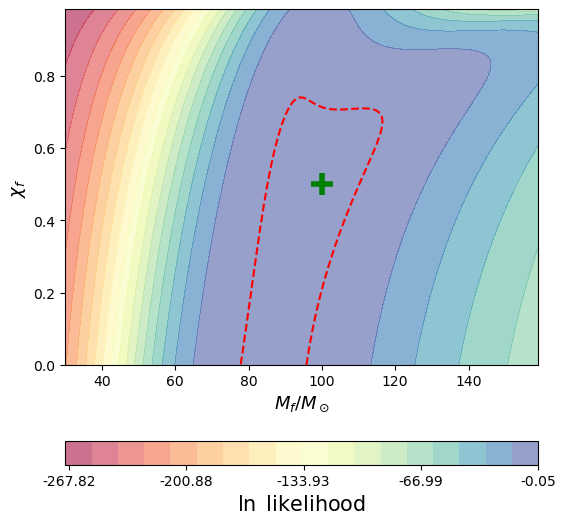

In [42]:
likelihood220_200 = result[5]
credible220_200 = qnm_filter.find_credible_region(likelihood220_200, num_cpu=10)


pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood220_200, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood220_200, [credible220_200], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=100, y=0.5, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood220_200), np.max(likelihood220_200), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

Text(0, 0.5, '$\\chi_f$')

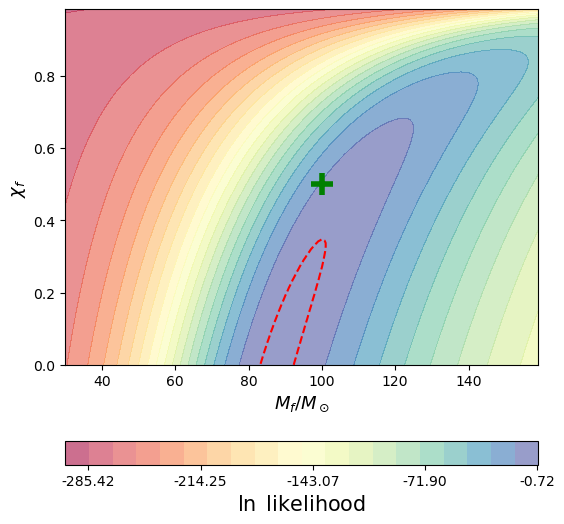

In [43]:
likelihood220 = result[4]
credible220 = qnm_filter.find_credible_region(likelihood220, num_cpu=10)

pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood220, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood220, [credible220], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=100, y=0.5, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood220), np.max(likelihood220), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

In [44]:
logsumexp(likelihood220)

4.204626320928024

In [45]:
logsumexp(likelihood220_200)

6.977733641556537